In [2]:
# Load libraries
import os
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load Dataset

In [3]:
# Define image and label array
images, labels = [], []

In [5]:
# Iter each folder
basedir = "dataset/"
for folder in tqdm(os.listdir(basedir)):

    # Iter each file
    folder_path = os.path.join(basedir, folder)
    for filename in os.listdir(folder_path):
        
        try:
        
            # Read image as RGB format + Resize (256, 256) and push into "images" & "labels" array
            filename = os.path.join(folder_path, filename)
            img = cv.imread(filename)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (256, 256))

            images.append(img)
            labels.append(folder)
            
        except Exception:
            print(filename)
            continue

 25%|█████████████████████                                                               | 1/4 [00:00<00:01,  1.82it/s]

dataset/Rain\rain141.jpg


 50%|██████████████████████████████████████████                                          | 2/4 [00:01<00:01,  1.10it/s]

dataset/Shine\shine131.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.11s/it]


In [6]:
# Transform list into np.array
images = np.array(images)
labels = np.array(labels)

In [7]:
# Check dimension
images.shape, labels.shape

((1470, 256, 256, 3), (1470,))

# Exploratory Data Analysis

In [8]:
# Load libraries 
import matplotlib.pyplot as plt

# Set matplotlib styling
plt.style.use("ggplot")

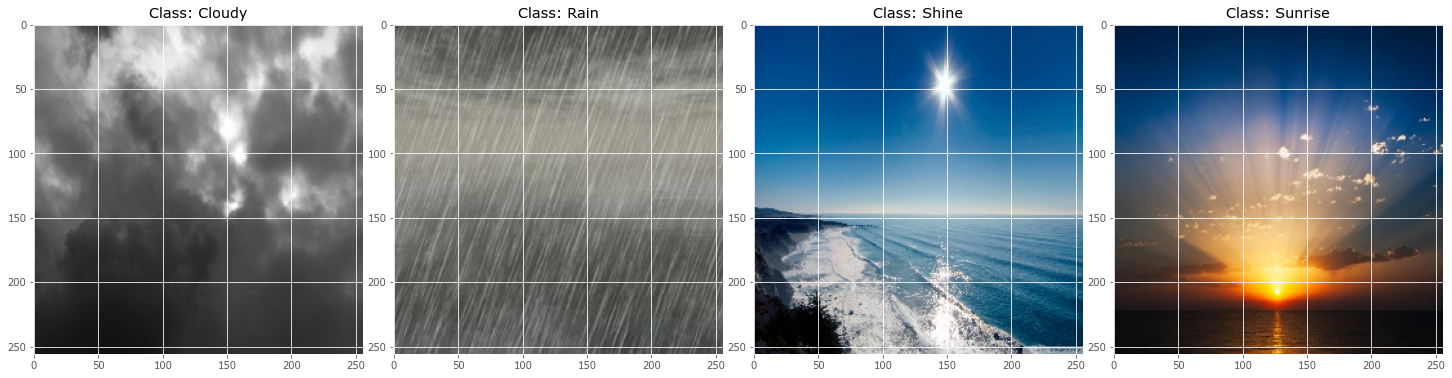

In [9]:
# Overview sample image on each class as figure
row, col = 1, 4
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_col, cls in enumerate(np.unique(labels)):
    image = images[list(labels).index(cls)]
    ax[n_col].imshow(image)
    ax[n_col].set_title(f"Class: {cls}")
    count += 1
        
plt.tight_layout(pad=0);

In [10]:
# Label Distribution
data = pd.DataFrame({"Labels" : labels})
pd.DataFrame(data['Labels'].value_counts())

# NOTE: Based on this label distribution we can overview if dataset is "imbalance" with least ratio significance

,Labels
Cloudy,600
Sunrise,357
Rain,261
Shine,252


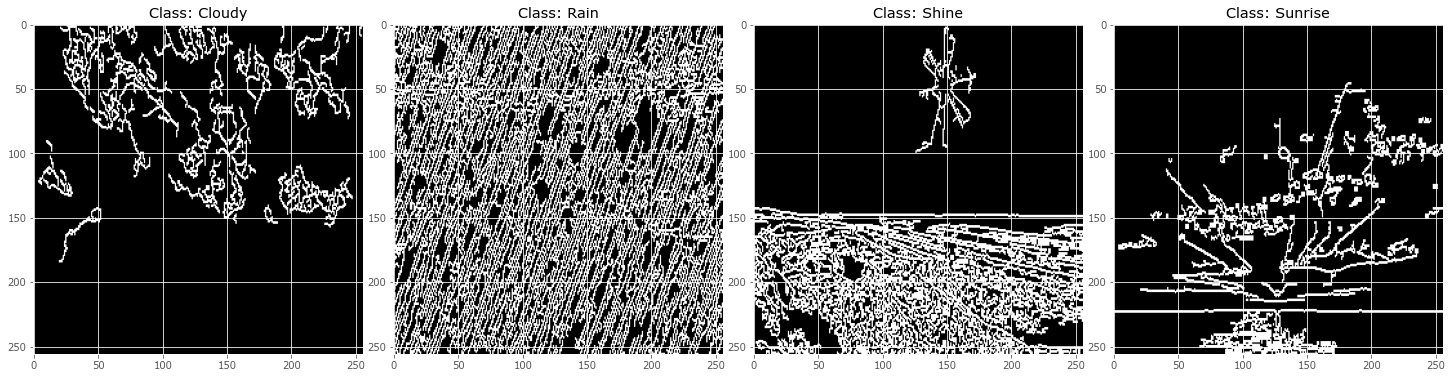

In [12]:
# Overview sample image on each class as figure
row, col = 1, 4
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_col, cls in enumerate(np.unique(labels)):
    image = images[list(labels).index(cls)]
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    image_segmented = cv.Canny(image, 10, 100)
    image_segmented = cv.dilate(image_segmented, (3, 3), 5)
    ax[n_col].imshow(image_segmented, cmap = "gray")
    ax[n_col].set_title(f"Class: {cls}")
    count += 1
        
plt.tight_layout(pad=0);

# Image Undersampling

![](https://www.researchgate.net/publication/367177472/figure/fig2/AS:11431281113378136@1673885739982/Random-undersampling-process.ppm)

In [13]:
# Load libraries
import random

In [14]:
# define function to pick random "True" value
def pick_random_true(list_boolean):
    true_indices = [i for i, value in enumerate(list_boolean) if value]
    random_index = random.choice(true_indices)
    return random_index

In [16]:
# Add 1 image on each cls if total labels is not equal to 301
images_undersampling = []
labels_undersampling = []

threshold = 252
for label in np.unique(labels):
    indices = labels == label
    n_label = labels[indices].shape[0]
    images_undersampling.extend(images[indices][:threshold])
    labels_undersampling.extend(labels[indices][:threshold])

In [18]:
# Label Distribution - after oversampling
data = pd.DataFrame({"Labels" : labels_undersampling})
pd.DataFrame(data['Labels'].value_counts())

,Labels
Cloudy,252
Rain,252
Shine,252
Sunrise,252


# Feature Extraction

![](https://forums.ni.com/t5/image/serverpage/image-id/122369iE970A9CE12BBCF03?v=v2)

In [19]:
# define function to generate Hu moment feature based on grayscale image
def fd_hu_moments(image):
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    feature = cv.HuMoments(cv.moments(image)).flatten()
    return feature

In [21]:
# feature hu moments
# Iter each image in oversampling mode and apply hu-moments
feature_hu_moments = list(map(lambda x: fd_hu_moments(x), images_undersampling))
feature_hu_moments = np.array(feature_hu_moments)

In [23]:
# Assign as label
features = pd.DataFrame.from_records(feature_hu_moments)
features.columns = [f"HU_{i}" for i in range(7)]

In [24]:
# Concat with label dataset
final_data = pd.concat([features, data], axis = 1)

# Overview final dataset
final_data.head()

,HU_0,HU_1,HU_2,HU_3,HU_4,HU_5,HU_6,Labels
0,0.001439,2.927617e-08,7.966457e-11,9.448530e-11,2.218248e-21,-1.492060e-14,-7.891617e-21,Cloudy
1,0.000972,2.536616e-08,2.102867e-11,5.710499e-13,-1.614116e-24,2.266235e-17,-1.144793e-24,Cloudy
2,0.001135,7.906478e-09,1.158719e-11,1.278067e-11,1.001988e-22,-4.478802e-16,1.189555e-22,Cloudy
3,0.001011,2.898048e-08,1.848338e-11,2.410678e-12,1.094528e-23,-4.049080e-16,1.179579e-23,Cloudy
4,0.001147,1.771165e-08,3.388428e-12,2.742973e-12,-1.420803e-24,3.540700e-16,8.240825e-24,Cloudy


# Data Modeling

In [25]:
# Load libraries
from sklearn.model_selection import train_test_split

In [26]:
# Split dataset into train-test with ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(final_data.drop("Labels", axis = 1), final_data['Labels'], test_size = 0.2)

# Check dimension
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((806, 7), (202, 7), (806,), (202,))

## SVM

In [27]:
# Load libraries
import seaborn as sn
from sklearn.svm import SVC
from warnings import filterwarnings
from sklearn.metrics import classification_report, confusion_matrix

filterwarnings("ignore")

In [28]:
# define function to visualize confusion matrix
def plot_custom_cm(true_labels, pred_labels, classes = list(np.unique(labels))):
    array = confusion_matrix(true_labels, pred_labels)
    df_cm = pd.DataFrame(array, columns = classes, index = classes)
    plt.figure(figsize = (20, 10))
    sn.set(font_scale = 1.4)
    sn.heatmap(df_cm, annot = True, annot_kws={"size": 16})

In [29]:
# Define classes
classes = list(np.unique(labels))

In [30]:
# Define algorithm
model_svm_baseline = SVC()
model_svm_baseline.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [31]:
# Training Algorithm
model_svm_baseline.fit(X_train, y_train)

SVC()

In [34]:
# Test on Training Set - classication_report
pred = model_svm_baseline.predict(X_train)
print(classification_report(y_train, pred, target_names = classes))

              precision    recall  f1-score   support

      Cloudy       0.94      0.94      0.94       199
        Rain       0.94      0.97      0.95       212
       Shine       0.97      0.97      0.97       198
     Sunrise       1.00      0.96      0.98       197

    accuracy                           0.96       806
   macro avg       0.96      0.96      0.96       806
weighted avg       0.96      0.96      0.96       806



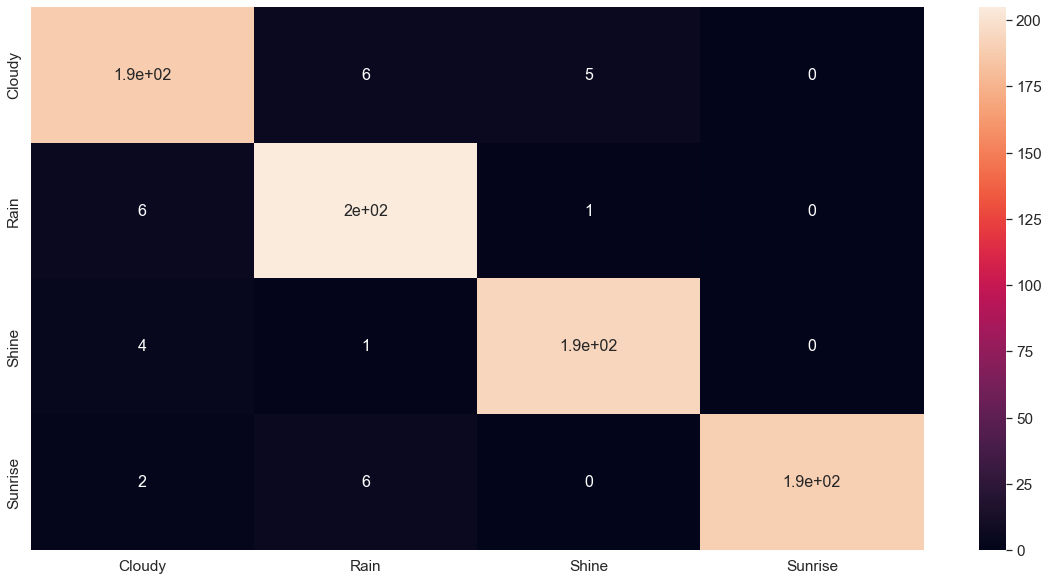

In [35]:
# Test on Training Set - confusion_matrix
plot_custom_cm(y_train, pred)

In [38]:
# Test on Training Set - classication_report
pred = model_svm_baseline.predict(X_test)
print(classification_report(y_test, pred, target_names = classes))

              precision    recall  f1-score   support

      Cloudy       0.94      0.94      0.94        53
        Rain       0.83      0.97      0.90        40
       Shine       1.00      0.98      0.99        54
     Sunrise       1.00      0.89      0.94        55

    accuracy                           0.95       202
   macro avg       0.94      0.95      0.94       202
weighted avg       0.95      0.95      0.95       202



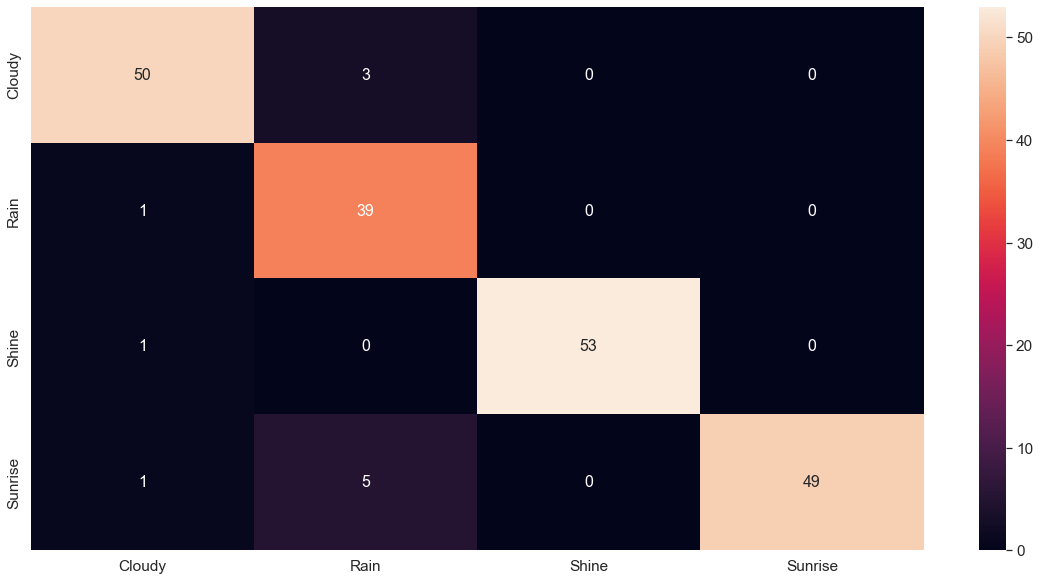

In [39]:
# Test on Training Set - confusion_matrix
plot_custom_cm(y_test, pred)

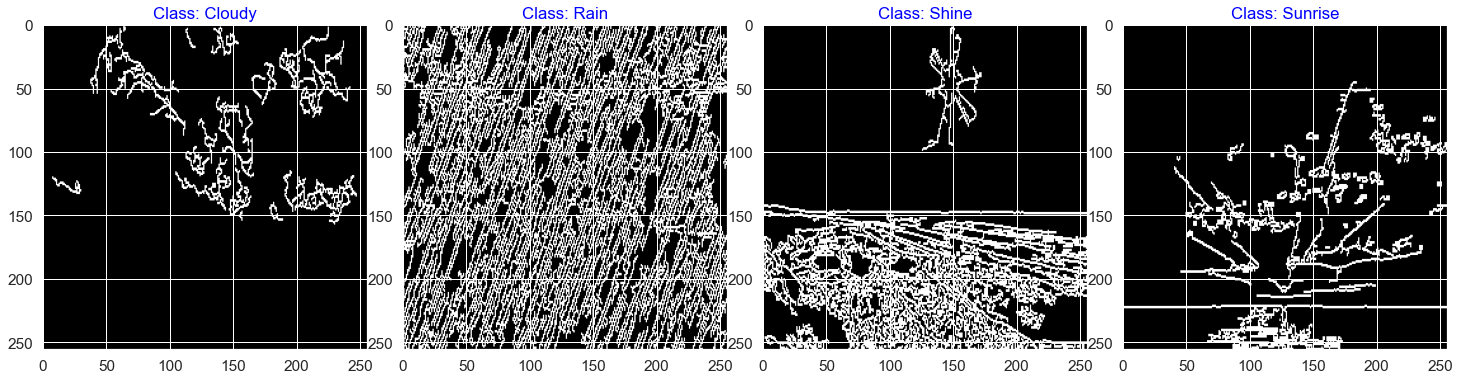

In [40]:
# Overview sample image on each class as figure
row, col = 1, 4
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_col, cls in enumerate(np.unique(labels)):
    image = images[list(labels).index(cls)]
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    image_segmented = cv.Canny(image, 10, 150)
    image_segmented = cv.dilate(image_segmented, (3, 3), 5)
    ax[n_col].imshow(image_segmented, cmap = "gray")
    ax[n_col].set_title(f"Class: {cls}")
    ax[n_col].title.set_color("blue" if preds_label == cls else "red")
    count += 1
        
plt.tight_layout(pad=0);
# NOTE: Blue color indicate "correct" prediction